# Задача мультиклаccификации на  кейс-чемпионате OilCase

## Задача -  создание модели машинного обучения по типу мультиклассификатор, способной предсказывать (классифицировать) принадлежность отрезка ГИС к классу фаций (баровое тело, лагуна, распределительный канал и тд).

## Данные - Командой Центра Хериот-Ватт разработана методология по оцифровке/извлечению фичей (геологически значимых признаков по данным сигналов ГИС). 

## Таргет - Флаг

## Метрика - Macro-averaged Precision

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore") 

/Users/dasha/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
train = pd.read_csv('OilCase/TRAIN.csv')
eval = pd.read_csv('OilCase/EVAL.csv')
test = pd.read_csv('OilCase/TEST.csv')

In [4]:
typegis = {
    '0' : 'Головных частей разрывных течений',
    '1' : 'Барьерных островов',
    '2' : 'Устьевых баров',
    '3' : 'Вдольбереговых баров (регрессивных) и прибрежных валов',
    '4' : 'Забаровых лагун и вдольбереговых промоин',
    '5' : 'Открытого моря и крупных морских заливов',
    '6' : 'Промоин разрывных течений',
    '7' : 'Пляжей',
    '8' : 'Вдольбереговых баров (трансгрессивных) и прибрежных валов',
    '9' : 'Гребней штормовых волн и приливных течений',
    '10' : 'Русловых отмелей спрямленных рек',
    '11' : 'Русловых отмелей фуркирующих рек (горного типа) и временных потоков',
    '12' : 'Русловых отмелей равнинных меандрирующих рек',
    '13' : 'Пески разливов',
    '14' : 'Пойменных озер и болот',
    '15' : 'Береговых валов',
    '16' : 'Временно заливаемых участков пойм',
    '17' : 'Приморских болот (маршей, лайд и др.)',
    '18' : 'Каньоны и каналы стока (питающие)',
    '19' : 'Проксимальные турбидиты и зерновые потоки',
    '20' : 'Средние (переходные) турбидиты',
    '21' : 'Дистальные турбидиты',
    '22' : 'Дно бассейна',
    '23' : 'Фации склона',
    '24' : 'Околоканальный вал',
    '25' : 'Верхний веер склона',
    '26' : 'Оползни',
    '27' : 'Дельтовый канал',
    '28' : 'Проксимальная часть дельты',
    '29' : 'Средняя часть дельты',
    '30' : 'Дистальная часть дельты',
    '31' : 'Продельта',
    '32' : 'Дюн',
    '33' : 'Empty'
}
inv_typegis = {v: k for k, v in typegis.items()}

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26399 entries, 0 to 26398
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Флаг               26399 non-null  object 
 1   МощностьКровЛиния  26399 non-null  float64
 2   МощностьПодшЛиния  26399 non-null  float64
 3   ДоляКровЛинии      26399 non-null  float64
 4   ДоляПодшЛинии      26399 non-null  float64
 5   УголКровЛиния      26399 non-null  float64
 6   УголПодшЛиния      26399 non-null  float64
 7   УголКровПод        26399 non-null  float64
 8   ОбщееКолЛиний      26399 non-null  int64  
 9   свТрендвВерх       25099 non-null  float64
 10  дУмЗ               25099 non-null  float64
 11  свТрендвВниз       26261 non-null  float64
 12  дУвЗ               26261 non-null  float64
 13  БЛ                 8662 non-null   float64
 14  дБЛ                8662 non-null   float64
 15  мощностьБЛ         8662 non-null   float64
 16  Угол_БЛ            866

In [6]:
train.columns

Index(['Флаг', 'МощностьКровЛиния', 'МощностьПодшЛиния', 'ДоляКровЛинии',
       'ДоляПодшЛинии', 'УголКровЛиния', 'УголПодшЛиния', 'УголКровПод',
       'ОбщееКолЛиний', 'свТрендвВерх', 'дУмЗ', 'свТрендвВниз', 'дУвЗ', 'БЛ',
       'дБЛ', 'мощностьБЛ', 'Угол_БЛ', 'УголБокКровл', 'УголБокПодш',
       'ОтношУголКровБок', 'ОтношУголПодшБок', 'МощКровИПодБок', 'G', 'S',
       'Am', 'P', 'Kp', 'm', 'R', 'Kc', 'Kt', 'quantile'],
      dtype='object')

In [7]:
train['Флаг'].value_counts()

Гребней штормовых волн и приливных течений                             836
Вдольбереговых баров (регрессивных) и прибрежных валов                 820
Открытого моря и крупных морских заливов                               817
Дистальная часть дельты                                                815
Русловых отмелей спрямленных рек                                       813
Продельта                                                              812
Устьевых баров                                                         808
Вдольбереговых баров (трансгрессивных) и прибрежных валов              808
Оползни                                                                808
Головных частей разрывных течений                                      806
Барьерных островов                                                     806
Забаровых лагун и вдольбереговых промоин                               805
Проксимальные турбидиты и зерновые потоки                              803
Промоин разрывных течений

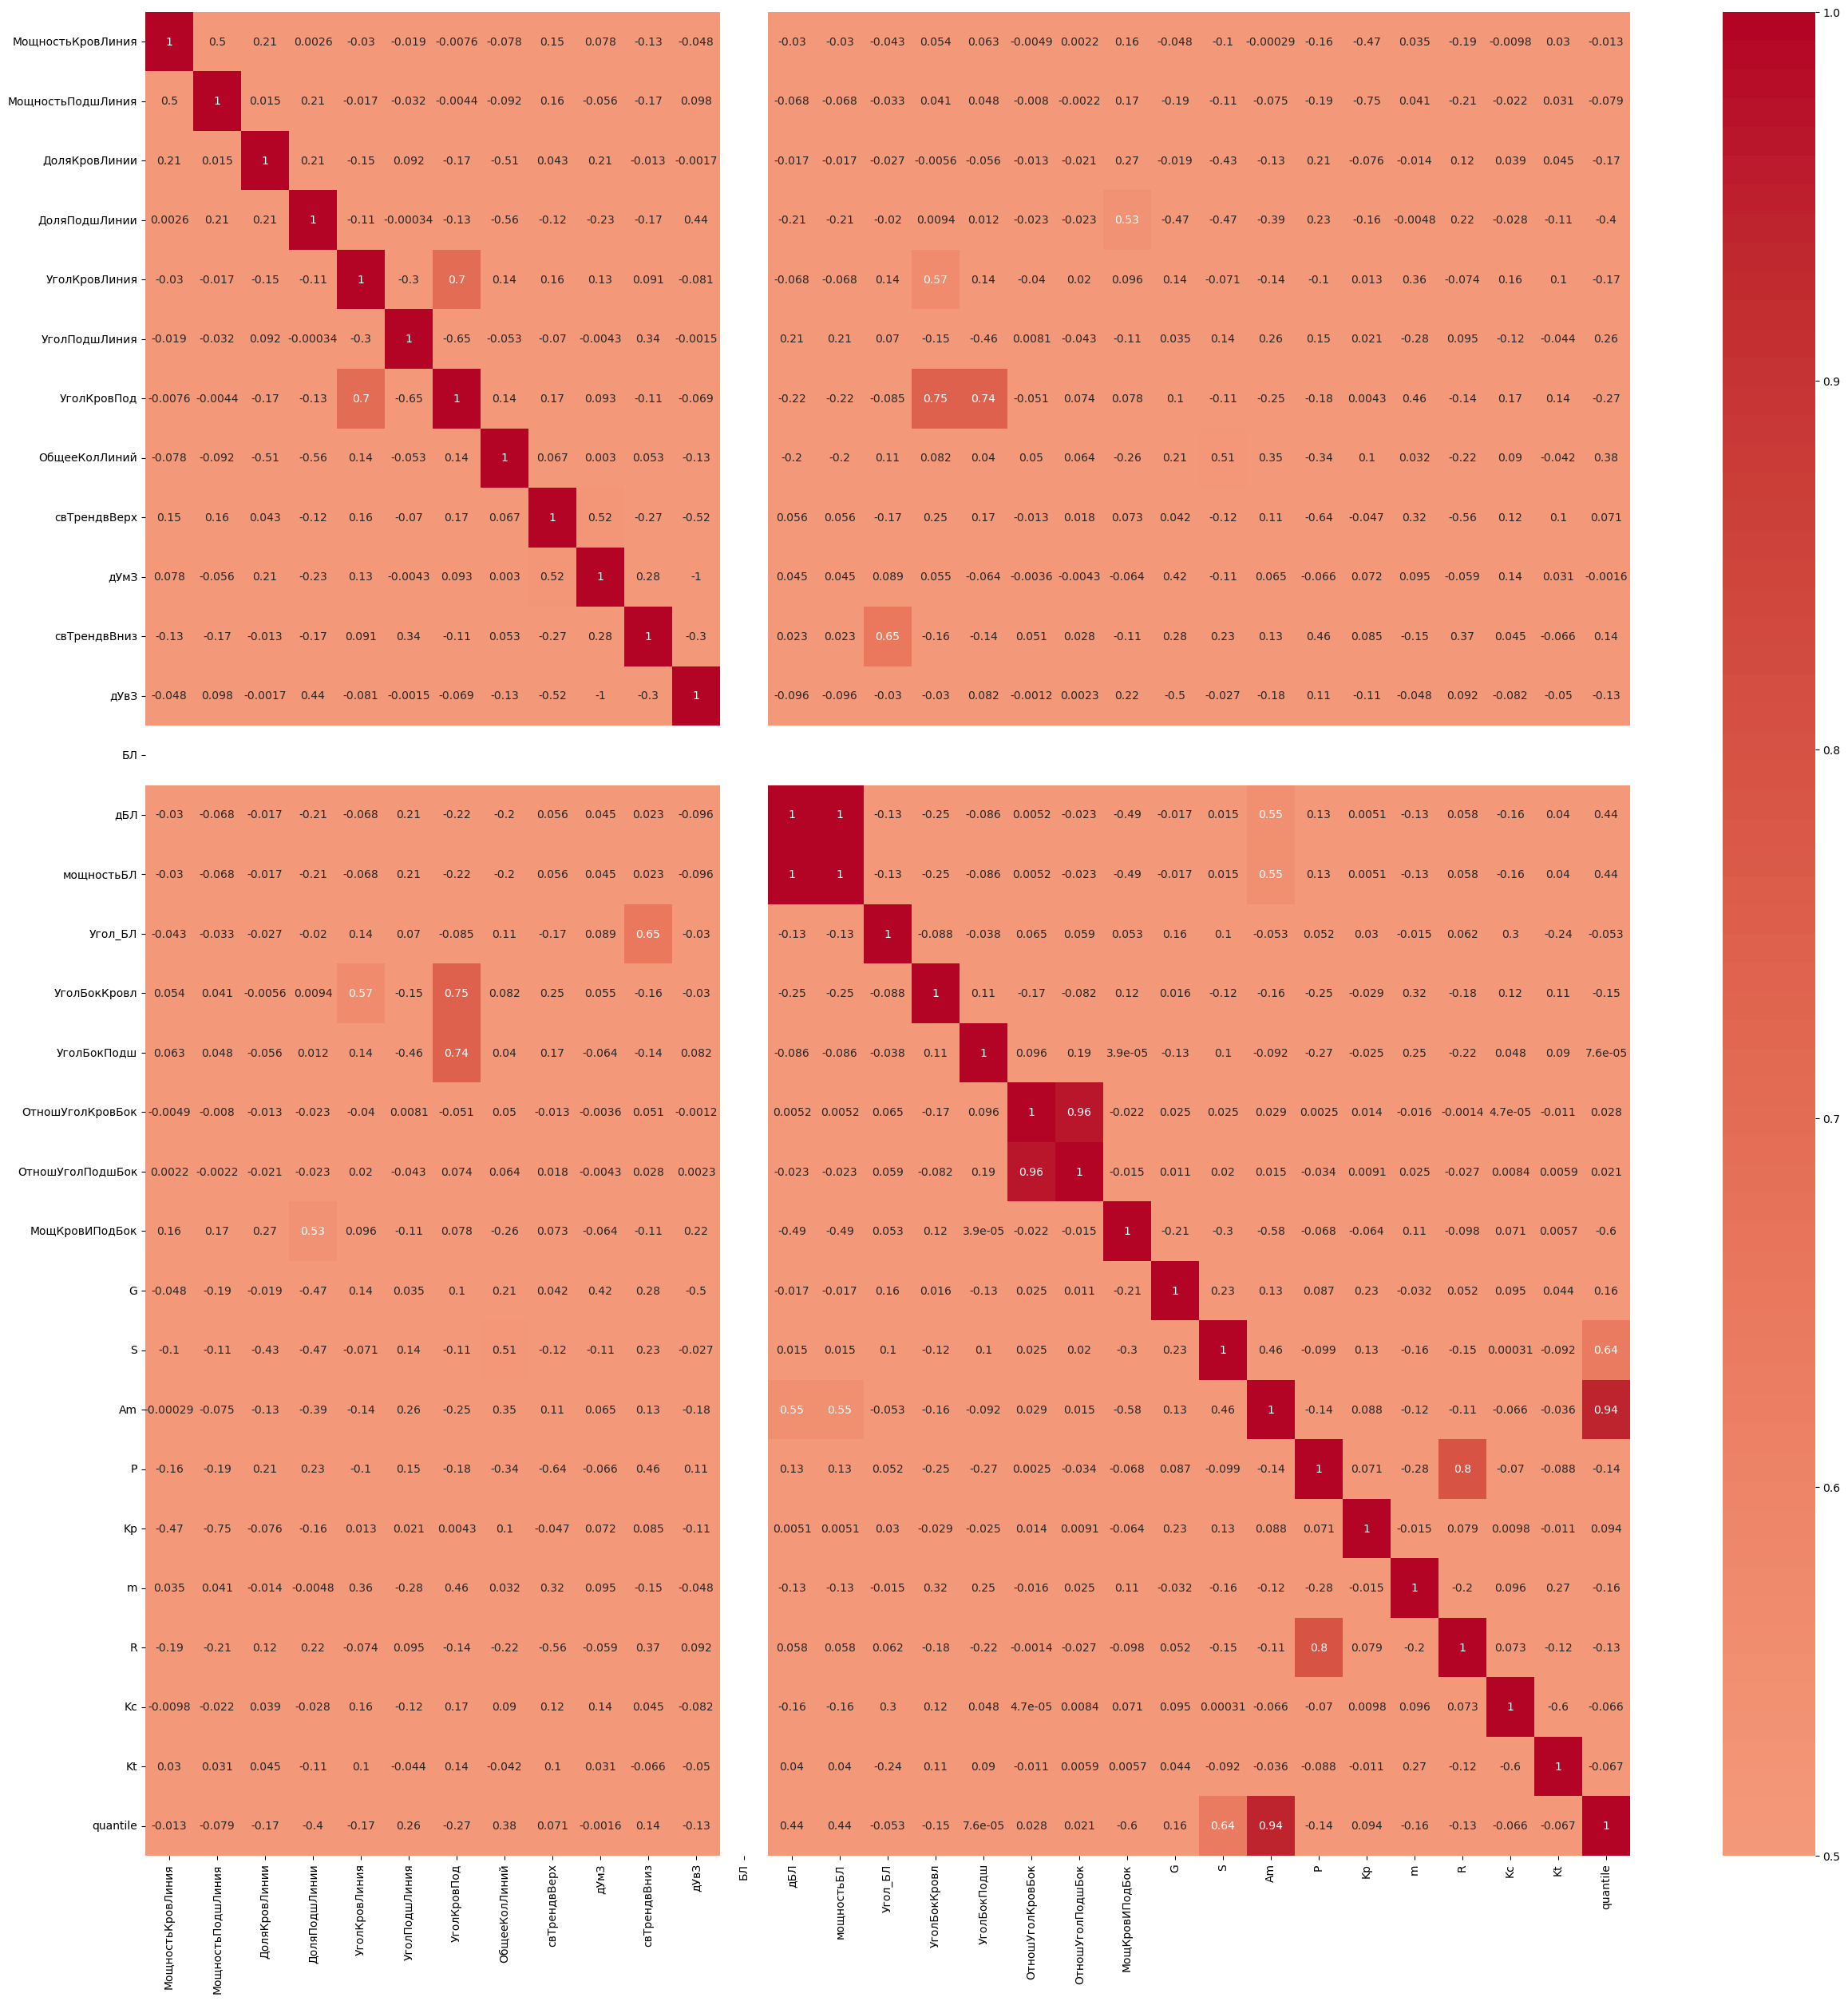

In [8]:
corr_matrix =  train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=0.5, vmax=1.0, center=0)
plt.show()

In [9]:
eval['Флаг'] = eval['Флаг'].map(inv_typegis)
eval = eval.astype(float)
train['Флаг'] = train['Флаг'].map(inv_typegis)
train = train.astype(float)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26399 entries, 0 to 26398
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Флаг               26399 non-null  float64
 1   МощностьКровЛиния  26399 non-null  float64
 2   МощностьПодшЛиния  26399 non-null  float64
 3   ДоляКровЛинии      26399 non-null  float64
 4   ДоляПодшЛинии      26399 non-null  float64
 5   УголКровЛиния      26399 non-null  float64
 6   УголПодшЛиния      26399 non-null  float64
 7   УголКровПод        26399 non-null  float64
 8   ОбщееКолЛиний      26399 non-null  float64
 9   свТрендвВерх       25099 non-null  float64
 10  дУмЗ               25099 non-null  float64
 11  свТрендвВниз       26261 non-null  float64
 12  дУвЗ               26261 non-null  float64
 13  БЛ                 8662 non-null   float64
 14  дБЛ                8662 non-null   float64
 15  мощностьБЛ         8662 non-null   float64
 16  Угол_БЛ            866

In [11]:
X = train.drop('Флаг', axis=1)
Y = train['Флаг']
X_eval = eval.drop('Флаг', axis=1)
Y_eval = eval['Флаг']

In [12]:
model1 = HistGradientBoostingClassifier(random_state=42, learning_rate=0.1082, max_iter=120,\
                                        min_samples_leaf=500, validation_fraction=0.11)
model1.fit(X, Y)
Y_eval_predict = model1.predict(X_eval)
macro_precision = precision_score(Y_eval, Y_eval_predict, average='macro')
print('Macro-averaged Precisionmacro_precision:',macro_precision)

Macro-averaged Precisionmacro_precision: 0.9615364401594035


In [13]:
data = pd.concat([train, eval], axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32060 entries, 0 to 5660
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Флаг               32060 non-null  float64
 1   МощностьКровЛиния  32060 non-null  float64
 2   МощностьПодшЛиния  32060 non-null  float64
 3   ДоляКровЛинии      32060 non-null  float64
 4   ДоляПодшЛинии      32060 non-null  float64
 5   УголКровЛиния      32060 non-null  float64
 6   УголПодшЛиния      32060 non-null  float64
 7   УголКровПод        32060 non-null  float64
 8   ОбщееКолЛиний      32060 non-null  float64
 9   свТрендвВерх       30471 non-null  float64
 10  дУмЗ               30471 non-null  float64
 11  свТрендвВниз       31892 non-null  float64
 12  дУвЗ               31892 non-null  float64
 13  БЛ                 10497 non-null  float64
 14  дБЛ                10497 non-null  float64
 15  мощностьБЛ         10497 non-null  float64
 16  Угол_БЛ            1049

In [14]:
X = data.drop('Флаг', axis=1)
Y = data['Флаг']
model1 = HistGradientBoostingClassifier(random_state=42, learning_rate=0.1082, max_iter=120, min_samples_leaf=500, validation_fraction=0.11)
model1.fit(X, Y)

HistGradientBoostingClassifier(learning_rate=0.1082, max_iter=120,
                               min_samples_leaf=500, random_state=42,
                               validation_fraction=0.11)

In [15]:
test = test.astype(float)
Y_test_predict = model1.predict(test.values)
df = pd.DataFrame({'predict': Y_test_predict})
df = df.astype(int)
df

,predict
0,23
1,21
2,2
3,5
4,1
...,...
934,5
935,14
936,8
937,11


## Выводы

Что дало прирост метрики :

1.Правильный выбор модели

2.Настройка гиперпараметров с помощью RandomizedSearchCV

3.Объединение тренировочной и валидационной выборок для предсказания классов

 Что не дало прирост метрики :
 
1.Обучение 2 моделей : первая для известных параметров , связанных с боковой линией фации, вторая - без них 2.Удаление наблюдений с пропусками

3.Замена пропусков на значения

4.Удаление мультиколлинеарности фичей

5.Отбор десяти самых значимых признаков для модели 

6.Масштабирование признаков для обучения

7. Введение в классификатор условия : не предсказывать значение 31 для наблюдений с неизвестными признаками для горизонтальной линии

8. Генерация новых фичей